# Boson sampling on a coherent state

We test the boson sampling operator (no training) 
on coherent states

We compare with theory

nonlinearxwaves@gmail.com<br>
@created 21 January 2021<br>
@version 1 October 2023

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages 

### Set project path

In [2]:
import numpy as np
import math
from thqml import phasespace as ps
from thqml.utilities import utilities
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [4]:
tf.keras.backend.clear_session()

In [5]:
np.set_printoptions(precision=2)

## free GPU memory

In [6]:
# this is commented and left for cuda use help if needed
#from numba import cuda 
#device = cuda.get_current_device()
#device.reset()
#cuda.close()

## Dimension

In [7]:
N = 2

## Build vacuum by the Gaussian state

In [8]:
vacuum = ps.VacuumLayer(N)

## Displacer

In [9]:
alpha =1.5*np.exp(1j)
dinput = tf.constant( [[np.sqrt(2)*np.real(alpha)], [np.sqrt(2)*np.imag(alpha)]], dtype=vacuum.dtype)
displacer = ps.DisplacementLayerConstant(dinput)

## Build the model

In [10]:
xin = tf.keras.layers.Input(N)
x1, a1 = displacer(xin)
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

# Evaluate the covariance

In [11]:
cov_layer = ps.covariance(N)
covariance_matrix, mean_R, hessian = cov_layer(chir,chii, model)
model_cov = tf.keras.Model(inputs = xin, outputs=[covariance_matrix, mean_R, hessian])
xtrain = np.random.rand(1, N)-0.5
cov0,d0, hessian0=model_cov(xtrain); tf.print(cov0); print(d0)

[[1 -0]
 [-0 1]]
tf.Tensor([[1.15 1.79]], shape=(1, 2), dtype=float32)


# Evaluate the Qtransform with calculated covariance and displacement

In [12]:
Qrho = ps.QTransform(cov0, d0)

In [13]:
# test the call to the Q-trasform
kin = tf.zeros_like(d0)
Qrho(kin)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.11]], dtype=float32)>

# Test the Pr operator 

Probability of zero photon

In [14]:
ps.Pr([0], Qrho)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.11]], dtype=float32)>

Probability of two photons

In [15]:
ps.Pr([2], Qrho)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.27], dtype=float32)>

## Define a function with the expected theoretical value

In [16]:
def Pcoherent(nj, alpha):
    # returh the theory value for photon distribution in a coherent state
    
    scale = 1

    aj2 = np.abs(alpha)**2
    scale = scale/np.math.factorial(nj)
    scale = scale*np.exp(-aj2)*np.power(aj2,nj)
    
    return scale    

## Make a plot versus the probability (may take few minutes for nmax>5)

In [17]:
%%time
nmax=6
Pn = np.zeros([nmax,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(nmax):
    print('Computing Pn at n '+repr(nbar))
    Pn[nbar]=ps.Pr([nbar],Qrho).numpy()
    Pth[nbar]=Pcoherent(nbar,alpha)
    xaxis[nbar]=nbar
print('Done')

Computing Pn at n 0
Computing Pn at n 1
Computing Pn at n 2
Computing Pn at n 3
Computing Pn at n 4
Computing Pn at n 5
Done
CPU times: user 31.3 s, sys: 131 ms, total: 31.5 s
Wall time: 31.5 s


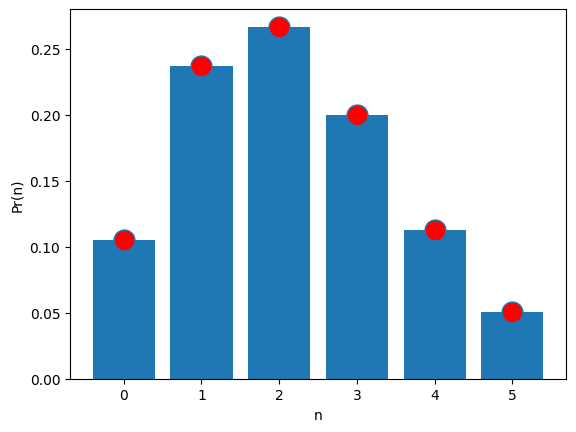

In [19]:
plt.bar(xaxis,Pn)
plt.plot(xaxis, Pth, marker='o', markersize=15, markerfacecolor='red', linestyle='none')
plt.xlabel('n');
plt.ylabel('Pr(n)');
plt.savefig('BosonSamplingExample1.pdf', format='pdf')

Comparison between the photon number evaluated with the model(bars) and the theory (red dots)